# Winter is coming, because the Indians are collecting firewood like crazy.

Team Members: Zichao Xiong, Yutao Yuan

In [1]:
import numpy as np
import pandas as pd
import pathlib
import os
from pandas_datareader.data import DataReader

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg as AR

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import BaggingClassifier

from mlf import mlf_plot
from mlf import feature_selection
from mlf import param_search

In [2]:
%load_ext autoreload
%autoreload 2

## 1. Introduction

### 1.1 Background

People want the macro-economy to get better every day. We don't want recessions or depressions, but bad things are often known only after they happen. Thus, an effective early warning method is waiting to be discovered. We hope to anticipate economic crises in advance, which will give us time to adopt governmental or fiscal policies (whether or not they actually work).

To accomplish this prediction, scientists usually assume that what has happened in the past will happen again in the future. Thus, historical data will provide us with enough information to make predictions. We will follow this idea by combining economic data and machine learning methods to identify or predict the onset of a recession.

### 1.2 Read Data from FRED

We read the following data from [Federal Reserve Economic Data](https://fred.stlouisfed.org/) (Fred). The codes of data are defined as follows:

1. `'IPMAN'`: Industrial production of manufacturing;
2. `'W875RX1'`: Real personal income;
3. `'CMRMTSPL'`: Real manufacturing and trade industries sales;
4. `'PAYEMS'`: Total number of employees;
5. `'FEDFUNDS'`: Federal funds effective interest rate;
6. `'CORESTICKM159SFRBATL'`: Consumer price index less food and energy;
7. `'USREC'`: (Target) Binary variable indicating whether America is in a recession or not.

In [8]:
start = '1950-01-01'
end = '2023-12-01'

# X variables
# Production related
production = DataReader('IPMAN', 'fred', start=start, end=end)
income = DataReader('W875RX1', 'fred', start=start, end=end)
sales = DataReader('CMRMTSPL', 'fred', start=start, end=end)
# Employment
employees = DataReader('PAYEMS', 'fred', start=start, end=end)
# Money related
interest_rate = DataReader('FEDFUNDS', 'fred', start=start, end=end)
# Consumption index
cpi = DataReader('CORESTICKM159SFRBATL', 'fred', start=start, end=end)

# y variables
recession = DataReader('USREC', 'fred', start=start, end=end)

In [4]:
# Concat all the data into dataframe
df_raw = pd.concat((production, income, sales, employees, interest_rate, cpi, recession), axis=1)
# Change column names
X_columns_raw = ['production', 'income', 'sales', 'employees', 'interest_rate', 'cpi']
columns_raw = X_columns_raw + ['recession']
df_raw.columns = columns_raw
df_raw.index.freq = df_raw.index.inferred_freq
df_raw.head()

,production,income,sales,employees,interest_rate,cpi,recession
DATE,,,,,,,
1950-01-01,NaN,NaN,NaN,43526,NaN,NaN,0
1950-02-01,NaN,NaN,NaN,43297,NaN,NaN,0
1950-03-01,NaN,NaN,NaN,43954,NaN,NaN,0
1950-04-01,NaN,NaN,NaN,44382,NaN,NaN,0
1950-05-01,NaN,NaN,NaN,44718,NaN,NaN,0


The plots of these six X variables will be shown as follows, where the gray regions denote recession periods.

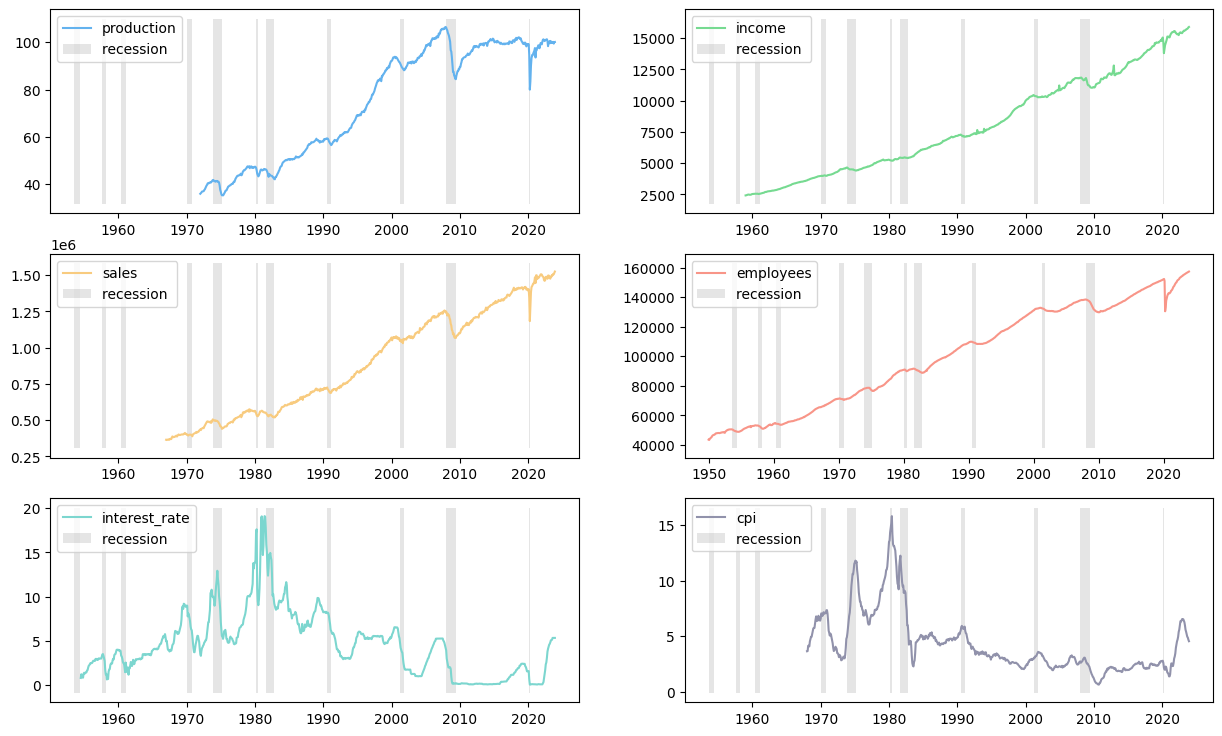

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,9))

mlf_colors = ['#63b2ee', '#76da91', '#f8cb7f', '#f89588', 
              '#7cd6cf', '#9192ab', '#7898e1', '#efa666', 
              '#eddd86', '#9987ce', '#63b2ee', '#76da91']

for k, column in enumerate(X_columns_raw):
    i, j = k//2, k%2
    axes[i, j].plot(df_raw.index, df_raw[column], label=column, c = mlf_colors[k])
    ylim = axes[i, j].get_ylim()
    axes[i, j].fill_between(df_raw.index, ylim[0], ylim[1], df_raw['recession'], facecolor='k', alpha=0.1, label = 'recession ')
    axes[i, j].legend(loc = 'upper left')

In [6]:
ungrouped_X_columns = []
grouped_X_columns = []
for column in X_columns_raw:
    foo = []
    for n in [1, 3, 6, 12]:
        # Name the differentiate variable as 'dln_***_*m'
        d_column_name = 'dln_' + column + '_' + str(n) + 'm'
        df_raw[d_column_name] = np.log(df_raw[column]) - np.log(df_raw[column].shift(n))
        ungrouped_X_columns.append(d_column_name)
        foo.append(d_column_name)
    grouped_X_columns.append(foo)

# Drop all the NaN rows
df = df_raw.dropna(axis=0)
df.head()

,production,income,sales,employees,interest_rate,cpi,recession,dln_production_1m,dln_production_3m,dln_production_6m,...,dln_employees_6m,dln_employees_12m,dln_interest_rate_1m,dln_interest_rate_3m,dln_interest_rate_6m,dln_interest_rate_12m,dln_cpi_1m,dln_cpi_3m,dln_cpi_6m,dln_cpi_12m
DATE,,,,,,,,,,,,,,,,,,,,,
1973-01-01,39.7323,4506.6,490599.001,75617,5.94,2.842803,0,0.007676,0.034782,0.069961,...,0.025556,0.042909,0.108358,0.162321,0.266582,0.526093,-0.101919,-0.158525,-0.198598,-0.271157
1973-02-01,40.3702,4523.8,491365.627,76014,6.58,2.881143,0,0.015927,0.037864,0.072608,...,0.024949,0.045292,0.102326,0.262668,0.313338,0.690112,0.013397,-0.126155,-0.155576,-0.287677
1973-03-01,40.4413,4525.8,489403.400,76284,7.09,2.929374,0,0.001760,0.025363,0.067304,...,0.026837,0.044771,0.074651,0.285334,0.375591,0.615821,0.016602,-0.071920,-0.064558,-0.325881
1973-04-01,40.3808,4539.4,487378.688,76455,7.12,3.031703,0,-0.001497,0.016190,0.050972,...,0.023570,0.044026,0.004222,0.181199,0.343519,0.534992,0.034336,0.064334,-0.094190,-0.269995
1973-05-01,40.6467,4556.1,485816.596,76648,7.84,3.175423,0,0.006563,0.006826,0.044690,...,0.022095,0.042360,0.096331,0.175204,0.437872,0.607625,0.046316,0.097254,-0.028901,-0.196227


### 1.3 Split Training set and Test Set

In [7]:
train_start = df.index[0]
train_end = '2005-12-01'

test_start = '2006-01-01'
test_end = '2023-12-01'

## 2. Identification

### 2.1 Hidden Markov Chain

The most famous way to analyze recessions is hidden markov chain and factor method. In general, it is assumed that both economic output and recession are determined by a hidden factor. Once we discover the factor through certain model, we can predict recessions using this factor.

<!-- ![Factor Model](graph/factor_model.jpg){height=80px} -->

<!-- <img src="graph/factor_model.jpg" alt="Factor Model" style="height:10%"> -->

<div>
<img src="graph/factor_model.jpg" width="300"/>
</div>

In this case, we define the model as follows
$$
\begin{align}
x_{i,t} & = \lambda_i f_t + u_{i,t} \\
u_{i,t} & = c_{i,1} u_{1,t-1} + c_{i,2} u_{i,t-2} + \varepsilon_{i,t} \qquad & \varepsilon_{i,t} \sim N(0, \sigma_i^2) \\
f_t & = a_1 f_{t-1} + a_2 f_{t-2} + \eta_t \qquad & \eta_t \sim N(0, I)\\
y_{t} & = \text{Logistic}(f_t) \\
\end{align}
$$

Here $x_{i, t}$ are `[production, income, sales, employees, interest_rate, cpi]`. $f_{i, t}$ is the hidden factor and $u_{i, t}$ is the error term. We assume that $f_{i, t}$ and $u_{i, t}$ follows AR(2) process. And recession indicator $y_{i, t}$ is a function of factor $f_{i, t}$.

In [8]:
X_columns_hmm = [column for column in ungrouped_X_columns if '1m' in column]
X_hmm = df[X_columns_hmm]

sc = StandardScaler()
X_hmm_std = sc.fit_transform(X_hmm)
X_hmm_std = pd.DataFrame(X_hmm_std, columns = X_columns_hmm, index=df.index)
model = sm.tsa.DynamicFactor(X_hmm_std, k_factors=1, factor_order=2, error_order=2)

initial_res = model.fit(method='powell', disp=False)
res = model.fit(initial_res.params, disp=False)
res.summary(separate_params=False).tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
loading.f1.dln_production_1m,-0.9713,0.043,-22.824,0.000,-1.055,-0.888
loading.f1.dln_income_1m,-0.4842,0.053,-9.181,0.000,-0.588,-0.381
loading.f1.dln_sales_1m,-0.6843,0.037,-18.347,0.000,-0.757,-0.611
loading.f1.dln_employees_1m,-0.7591,0.045,-16.744,0.000,-0.848,-0.670
loading.f1.dln_interest_rate_1m,-0.5230,0.033,-15.768,0.000,-0.588,-0.458
loading.f1.dln_cpi_1m,-0.0901,0.051,-1.778,0.075,-0.189,0.009
sigma2.dln_production_1m,4.715e-05,5.42e-05,0.871,0.384,-5.9e-05,0.000
sigma2.dln_income_1m,0.7431,0.020,37.022,0.000,0.704,0.782
sigma2.dln_sales_1m,0.4287,0.023,18.426,0.000,0.383,0.474
sigma2.dln_employees_1m,0.4068,0.036,11.419,0.000,0.337,0.477


We can see that coefficients of $f_{i, t}$ on productions, sales, income and employees are all negative, which means that $f_{i, t}$ is a factor depicting recession to some degree. But the relationship between $f_{i, t}$ and binary $y$ is not so straight forward.

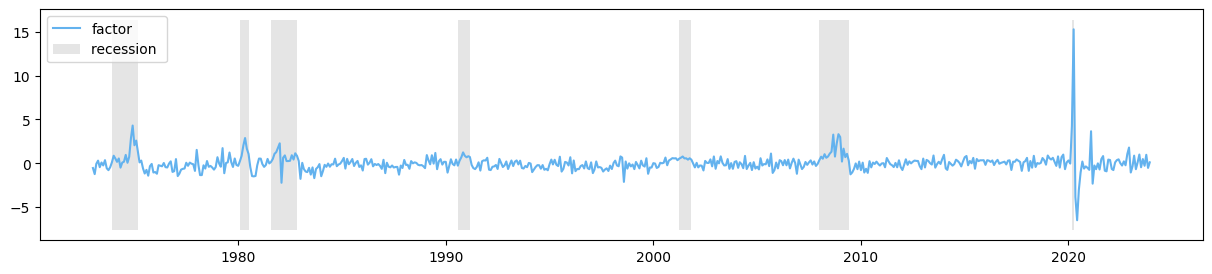

In [9]:
factor = res.factors.filtered[0]

fig, ax = plt.subplots(figsize=(15,3))
ax.plot(df.index, factor, label='factor', c = mlf_colors[0])
ylim = ax.get_ylim()
ax.fill_between(df.index, ylim[0], ylim[1], df['recession'], facecolor='k', alpha=0.1, label='recession ')
ax.legend(loc='upper left')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(factor.reshape(-1, 1), df['recession'].to_numpy(), test_size=0.3, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
print(f'The identification accuracy of factor model is {model.score(X_test, y_test):.4f}')

The identification accuracy of factor model is 0.8913


The results of hidden markov chain is not so satisfying. Maybe it can be improved by setting more complicated models.

### 2.2 Machine Learning Methods

The main topic of this project is to use machine learning methods to identify and predict recessions. As mentioned before, we created a lot of X variables (6 original features times 4 kinds of difference). At this point we are often expected to do feature extraction or feature selection. First let us define the training dataset and testing dataset based on time.

In [11]:
X_train = df.loc[train_start:train_end, ungrouped_X_columns]
y_train = df.loc[train_start:train_end, 'recession']

X_test = df.loc[test_start:test_end, ungrouped_X_columns]
y_test = df.loc[test_start:test_end, 'recession']

#### 2.2.1 All Feature Used

More information is not always best, and we will illustrate this by using all features in the beginning.

In [12]:
identification_score_unselected = param_search.multi_search(X_train, y_train, X_test, y_test, feature_type = 'unselected')
display(identification_score_unselected)

feature_type unselected          
score          accuracy   roc_auc
lr             0.916667  0.982908
svm            0.953704  0.973980
rf             0.953704  0.965051

#### 2.2.2 Feature Extraction (PCA)

In previous lessons, we learned ways to extract new variables from the original features. The most common one is PCA, but it has two drawbacks:

1. The new data has less economic meanings and are harder to understand intuitively;
2. This method is unsupervised so it may ignore the y variable.

In [13]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
length, width = X_train_std.shape

pca = PCA(n_components=5)
pca.fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

identification_score_pca = param_search.multi_search(X_train_pca, y_train, X_test_pca, y_test, std = False, feature_type = 'pca')
display(identification_score_pca)

feature_type       pca          
score         accuracy   roc_auc
lr            0.953704  0.982143
svm           0.925926  0.981633
rf            0.949074  0.939541

#### 2.2.3 Feature Selection (L1 Norm LR Feature Selection)

If we prefer to preserve the original data meaning, what we should do is feature selection. A common approach is to select features based on sparsity of L1-norm regression. Here we decide to choose no more than 12 features to identify recessions.

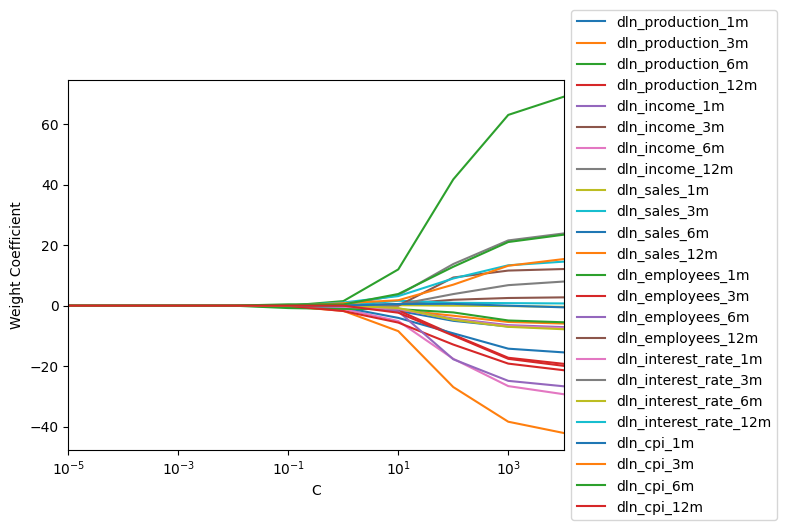

In [14]:
lr_feature_selection = feature_selection.LogisticFeatureSelection(X_train, y_train, np.array(ungrouped_X_columns))
lr_feature_selection.lr_fit()
lr_feature_selection.lr_plot_feature()
feature_column_lr = lr_feature_selection.lr_select_feature(less_than = 12)

In [15]:
print('The selected features are: ', feature_column_lr)

X_train_l1_lr = df.loc[train_start:train_end, feature_column_lr]
X_test_l1_lr = df.loc[test_start:test_end, feature_column_lr]

identification_score_l1_lr = param_search.multi_search(X_train_l1_lr, y_train, X_test_l1_lr, y_test, feature_type = 'l1_lr')
display(identification_score_l1_lr)

The selected features are:  ['dln_production_1m' 'dln_production_3m' 'dln_income_3m' 'dln_income_6m'
 'dln_sales_3m' 'dln_sales_6m' 'dln_sales_12m' 'dln_employees_1m'
 'dln_employees_3m' 'dln_cpi_3m' 'dln_cpi_6m']


feature_type     l1_lr          
score         accuracy   roc_auc
lr            0.958333  0.988265
svm           0.949074  0.984184
rf            0.953704  0.972959

#### 2.2.4 Feature Selection (Semi-auto Method)

One question for L1 norm LR is why the features selected via LR can be applied to other machine learning methods (e.g. SVM or DT). We also find a large imbalance in the features selected by this method, with too many sales related features selected, but no interest related features.

Moro et al. (2014) use a semi-auto feature selection method. It is called semi-automatic because this method requires first grouping features using intuition, and then for each group various machine learning methods can be applied to select features. The process is given as follows:

<div>
<img src="graph/semiauto_step_1.jpg" height="300"/>
</div>

<div>
<img src="graph/semiauto_step_2.jpg" height="400"/>
</div>

<div>
<img src="graph/semiauto_step_3.jpg" height="300"/>
</div>

In [16]:
clf1 = LogisticRegression(penalty='l2', 
                          C=0.1,
                          solver='lbfgs',
                          random_state=1)

clf2 = SVC(kernel='rbf', 
           gamma=0.1,
           C=10,
           random_state=1,
           probability=True)

clf3 = RandomForestClassifier(n_estimators=100,
                              criterion='entropy',
                              max_depth=6,
                              bootstrap=True,
                              random_state=1)

classifiers = [clf1, clf2, clf3]

sel = feature_selection.SemiautoFeatureSelection(T1 = 0.6, T2 = 0.65, T3 = 0.01, T4 = 0.7, classifiers = classifiers)
sel.comp_score(X_train, y_train, X_test, y_test, grouped_X_columns)
label = sel.first_select(grouped_X_columns)
group_SemiautoFeatureSelection = sel.second_select(X_train, y_train, label)

In [17]:
X_train_semiauto = df.loc[train_start:train_end]
X_test_semiauto = df.loc[test_start:test_end]

accuracy_lr, roc_auc_lr = param_search.lr_search(X_train_semiauto[group_SemiautoFeatureSelection[clf1]], y_train, 
                                                 X_test_semiauto[group_SemiautoFeatureSelection[clf1]], y_test)
accuracy_svm, roc_auc_svm = param_search.svm_search(X_train_semiauto[group_SemiautoFeatureSelection[clf2]], y_train, 
                                                    X_test_semiauto[group_SemiautoFeatureSelection[clf2]], y_test)
accuracy_rf, roc_auc_rf = param_search.rf_search(X_train_semiauto[group_SemiautoFeatureSelection[clf3]], y_train, 
                                                 X_test_semiauto[group_SemiautoFeatureSelection[clf3]], y_test)

multi_index = pd.MultiIndex.from_product([['semiauto'], ['accuracy', 'roc_auc']], names=['feature_type', 'score'])
index = ['lr','svm','rf']
data = np.array([[accuracy_lr, roc_auc_lr], [accuracy_svm, roc_auc_svm], [accuracy_rf, roc_auc_rf]])
identification_score_semiauto = pd.DataFrame(data, index = index, columns = multi_index)
display(identification_score_semiauto)

feature_type  semiauto          
score         accuracy   roc_auc
lr            0.967593  0.990051
svm           0.953704  0.979719
rf            0.962963  0.956378

### 2.4 Comparison

In [18]:
identification_score = pd.concat((identification_score_unselected, identification_score_l1_lr, identification_score_semiauto), axis=1)
display(identification_score)

feature_type unselected               l1_lr            semiauto          
score          accuracy   roc_auc  accuracy   roc_auc  accuracy   roc_auc
lr             0.916667  0.982908  0.958333  0.988265  0.967593  0.990051
svm            0.953704  0.973980  0.949074  0.984184  0.953704  0.979719
rf             0.953704  0.965051  0.953704  0.972959  0.962963  0.956378

feature_type       pca           unselected               l1_lr            \
score         accuracy   roc_auc   accuracy   roc_auc  accuracy   roc_auc   
lr            0.953704  0.982143   0.916667  0.982908  0.958333  0.988265   
svm           0.925926  0.981633   0.953704  0.973980  0.949074  0.984184   
rf            0.949074  0.939541   0.953704  0.965051  0.953704  0.972959   

feature_type  semiauto            
score         accuracy   roc_auc  
lr            0.967593  0.990051  
svm           0.953704  0.979719  
rf            0.962963  0.956378

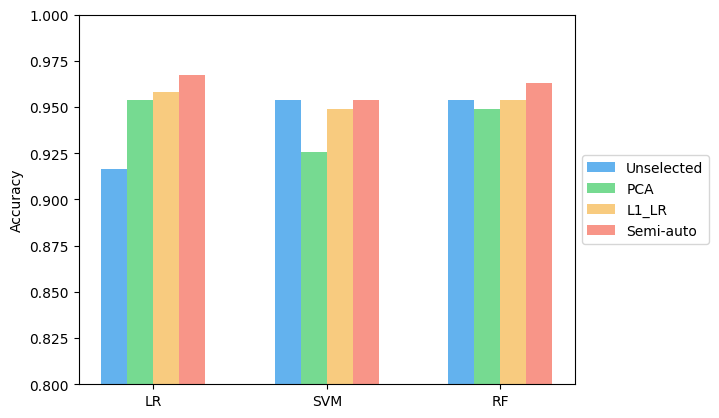

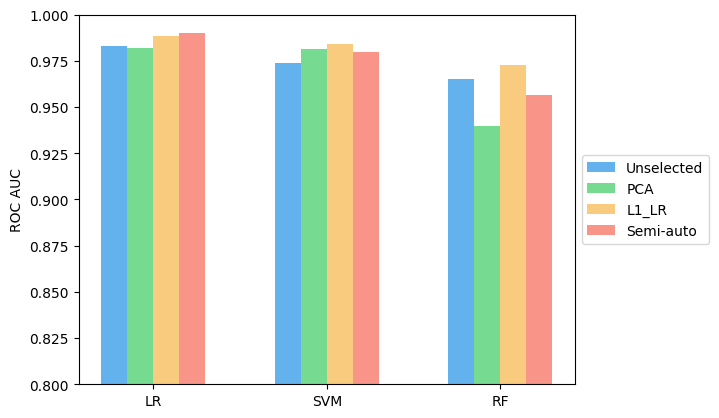

In [19]:
identification_score = pd.concat((identification_score_pca, identification_score_unselected, identification_score_l1_lr, identification_score_semiauto), axis=1)
display(identification_score)

labels = ['LR', 'SVM', 'RF']
x = np.arange(len(labels))
bar_width = 0.15

fig, ax = plt.subplots()
rects0 = ax.bar(x - 1.5*bar_width, identification_score[('unselected', 'accuracy')], bar_width, color = mlf_colors[0], label='Unselected')
rects1 = ax.bar(x - 0.5*bar_width, identification_score[('pca', 'accuracy')], bar_width, color = mlf_colors[1], label='PCA')
rects2 = ax.bar(x + 0.5*bar_width, identification_score[('l1_lr', 'accuracy')], bar_width, color = mlf_colors[2], label='L1_LR')
rects3 = ax.bar(x + 1.5*bar_width, identification_score[('semiauto', 'accuracy')], bar_width, color = mlf_colors[3], label='Semi-auto')

ax.set_ylim((0.8, 1.0))
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

labels = ['LR', 'SVM', 'RF']
x = np.arange(len(labels))
bar_width = 0.15

fig, ax = plt.subplots()
rects0 = ax.bar(x - 1.5*bar_width, identification_score[('unselected', 'roc_auc')], bar_width, color = mlf_colors[0], label='Unselected')
rects1 = ax.bar(x - 0.5*bar_width, identification_score[('pca', 'roc_auc')], bar_width, color = mlf_colors[1], label='PCA')
rects2 = ax.bar(x + 0.5*bar_width, identification_score[('l1_lr', 'roc_auc')], bar_width, color = mlf_colors[2], label='L1_LR')
rects3 = ax.bar(x + 1.5*bar_width, identification_score[('semiauto', 'roc_auc')], bar_width, color = mlf_colors[3], label='Semi-auto')

ax.set_ylim((0.8, 1.0))
ax.set_ylabel('ROC AUC')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

## 3. Prediction

Note that in the previous chapter, we accomplish just the identification, i.e., using the independent variable for a given month to compute the dependent variable for the same month. This may yield good results, but it is not very practical, due to two reasons:

1. When we get this month's economic data, it is also determined that a recession is happening or not;
2. To make matters worse, some economic data is less current, which means that we can't access the current month's data until about two months later, and then the act of identification becomes just a historiographical study.

So we are more curious about whether machine learning algorithms can predict recessions. We will define the following variable: `'recession_in_6m'`. This variable represents whether, for any month $t$, a recession occurred from month $t$ to $t+5$. If so, then `'recession_in_6m'` will take the value of 1 and otherwise 0.

In [20]:
df_pred = df.copy()
foo = df_pred.sort_index(ascending=False)
foo.loc[:, 'recession_in_6m'] = foo.loc[:, 'recession'].rolling(6, min_periods=1).max().astype('int')
df_pred = foo.sort_index(ascending=True)
df_pred.drop(columns='recession', inplace=True)
df_pred.dropna(inplace=True)

X_train_pred = df_pred.loc[train_start:train_end, ungrouped_X_columns]
y_train_pred = df_pred.loc[train_start:train_end, 'recession_in_6m']

X_test_pred = df_pred.loc[test_start:test_end, ungrouped_X_columns]
y_test_pred = df_pred.loc[test_start:test_end, 'recession_in_6m']

As we have done before, we will predict recessions by 4 steps:

1. Use all features;
2. Extract features by PCA;
3. Use L1-LR to select features;
4. Use semi-auto method to select feature.

### 3.1 All Features Used

In [21]:
prediction_score_unselected = param_search.multi_search(X_train_pred, y_train_pred, X_test_pred, y_test_pred, feature_type = 'unselected')
display(prediction_score_unselected)

feature_type unselected          
score          accuracy   roc_auc
lr             0.824074  0.812186
svm            0.847222  0.844803
rf             0.879630  0.852330

### 3.2 Feature Extraction (PCA)

In [22]:
X_train_pred_std = sc.fit_transform(X_train_pred)
X_test_pred_std = sc.transform(X_test_pred)
pca = PCA(n_components=5)
pca.fit(X_train_pred_std)
X_train_pred_pca = pca.transform(X_train_pred_std)
X_test_pred_pca = pca.transform(X_test_pred_std)

prediction_score_pca = param_search.multi_search(X_train_pred_pca, y_train_pred, X_test_pred_pca, y_test_pred, std = False, feature_type = 'pca')
display(prediction_score_pca)

feature_type       pca          
score         accuracy   roc_auc
lr            0.805556  0.810394
svm           0.833333  0.795609
rf            0.796296  0.803674

### 3.3 Feature Selection (L1 Norm LR Feature Selection)

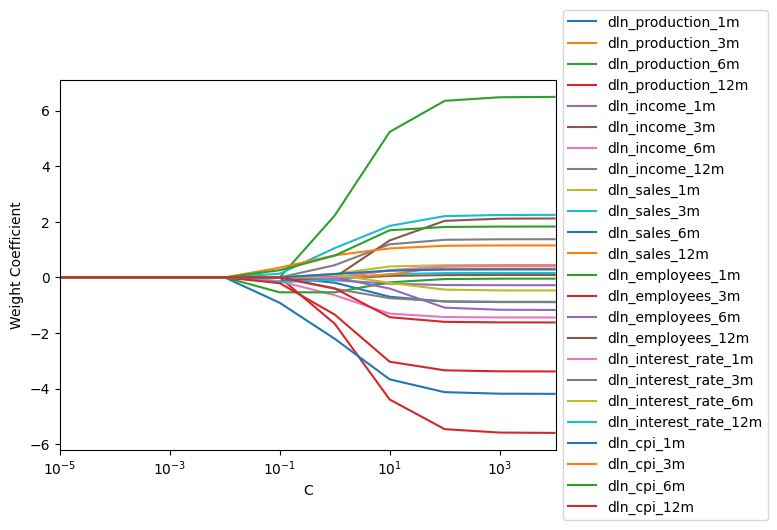

In [23]:
lr_feature_selection = feature_selection.LogisticFeatureSelection(X_train_pred, y_train_pred, np.array(ungrouped_X_columns))
lr_feature_selection.lr_fit()
lr_feature_selection.lr_plot_feature()
feature_column_lr = lr_feature_selection.lr_select_feature(less_than = 12)

In [24]:
print('The selected features are: ', feature_column_lr)

X_train_pred_l1_lr = df_pred.loc[train_start:train_end, feature_column_lr]
X_test_pred_l1_lr = df_pred.loc[test_start:test_end, feature_column_lr]

prediction_score_l1_lr = param_search.multi_search(X_train_pred_l1_lr, y_train_pred, X_test_pred_l1_lr, y_test_pred, feature_type = 'l1_lr')
display(prediction_score_l1_lr)

The selected features are:  ['dln_income_3m' 'dln_income_6m' 'dln_sales_3m' 'dln_sales_6m'
 'dln_employees_1m' 'dln_employees_3m' 'dln_interest_rate_12m'
 'dln_cpi_3m' 'dln_cpi_6m']


feature_type     l1_lr          
score         accuracy   roc_auc
lr            0.842593  0.827957
svm           0.842593  0.849283
rf            0.912037  0.906004

### 3.4 Feature Selection (Semi-auto Method)

In [25]:
clf1 = LogisticRegression(penalty='l2', 
                          C=0.1,
                          solver='lbfgs',
                          random_state=1)

clf2 = SVC(kernel='rbf', 
           gamma=0.1,
           C=10,
           random_state=1,
           probability=True)

clf3 = RandomForestClassifier(n_estimators=100,
                              criterion='entropy',
                              max_depth=6,
                              bootstrap=True,
                              random_state=1)

classifiers = [clf1, clf2, clf3]

sel = feature_selection.SemiautoFeatureSelection(T1 = 0.6, T2 = 0.65, T3 = 0.01, T4 = 0.7, classifiers = classifiers)
sel.comp_score(X_train_pred, y_train_pred, X_test_pred, y_test_pred, grouped_X_columns)
label = sel.first_select(grouped_X_columns)
group_SemiautoFeatureSelection = sel.second_select(X_train_pred, y_train_pred, label)

In [26]:
X_train_pred_semiauto = df_pred.loc[train_start:train_end]
X_test_pred_semiauto = df_pred.loc[test_start:test_end]

accuracy_lr, roc_auc_lr = param_search.lr_search(X_train_pred_semiauto[group_SemiautoFeatureSelection[clf1]], y_train_pred, 
                                                 X_test_pred_semiauto[group_SemiautoFeatureSelection[clf1]], y_test_pred)
accuracy_svm, roc_auc_svm = param_search.svm_search(X_train_pred_semiauto[group_SemiautoFeatureSelection[clf2]], y_train_pred, 
                                                    X_test_pred_semiauto[group_SemiautoFeatureSelection[clf2]], y_test_pred)
accuracy_rf, roc_auc_rf = param_search.rf_search(X_train_pred_semiauto[group_SemiautoFeatureSelection[clf3]], y_train_pred, 
                                                 X_test_pred_semiauto[group_SemiautoFeatureSelection[clf3]], y_test_pred)

multi_index = pd.MultiIndex.from_product([['semiauto'], ['accuracy', 'roc_auc']], names=['feature_type', 'score'])
index = ['lr','svm','rf']
data = np.array([[accuracy_lr, roc_auc_lr], [accuracy_svm, roc_auc_svm], [accuracy_rf, roc_auc_rf]])
prediction_score_semiauto = pd.DataFrame(data, index = index, columns = multi_index)
display(prediction_score_semiauto)

feature_type  semiauto          
score         accuracy   roc_auc
lr            0.912037  0.915771
svm           0.898148  0.873208
rf            0.902778  0.897760

### 3.5 Comparison

feature_type       pca           unselected               l1_lr            \
score         accuracy   roc_auc   accuracy   roc_auc  accuracy   roc_auc   
lr            0.805556  0.810394   0.824074  0.812186  0.842593  0.827957   
svm           0.833333  0.795609   0.847222  0.844803  0.842593  0.849283   
rf            0.796296  0.803674   0.879630  0.852330  0.912037  0.906004   

feature_type  semiauto            
score         accuracy   roc_auc  
lr            0.912037  0.915771  
svm           0.898148  0.873208  
rf            0.902778  0.897760

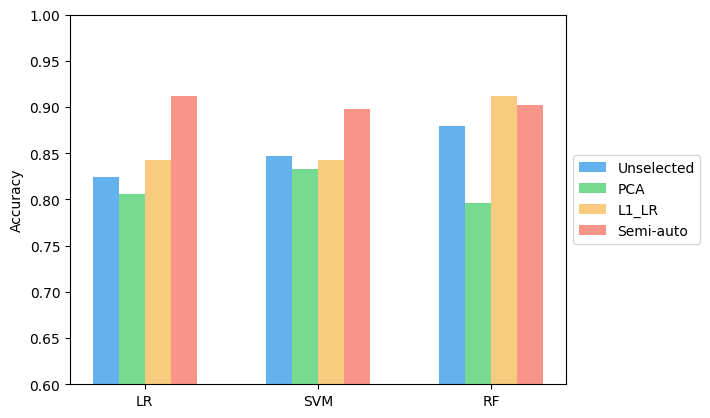

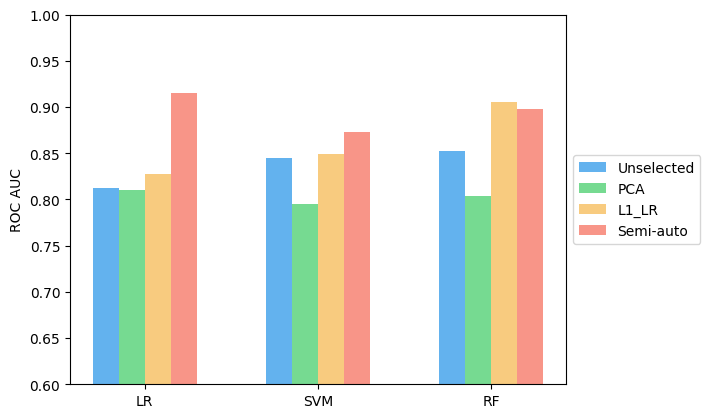

In [27]:
prediction_score = pd.concat((prediction_score_pca, prediction_score_unselected, prediction_score_l1_lr, prediction_score_semiauto), axis=1)
display(prediction_score)

labels = ['LR', 'SVM', 'RF']
x = np.arange(len(labels))
bar_width = 0.15

fig, ax = plt.subplots()
rects0 = ax.bar(x - 1.5*bar_width, prediction_score[('unselected', 'accuracy')], bar_width, color = mlf_colors[0], label='Unselected')
rects1 = ax.bar(x - 0.5*bar_width, prediction_score[('pca', 'accuracy')], bar_width, color = mlf_colors[1], label='PCA')
rects2 = ax.bar(x + 0.5*bar_width, prediction_score[('l1_lr', 'accuracy')], bar_width, color = mlf_colors[2], label='L1_LR')
rects3 = ax.bar(x + 1.5*bar_width, prediction_score[('semiauto', 'accuracy')], bar_width, color = mlf_colors[3], label='Semi-auto')

ax.set_ylim((0.6, 1.0))
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

labels = ['LR', 'SVM', 'RF']
x = np.arange(len(labels))
bar_width = 0.15

fig, ax = plt.subplots()
rects0 = ax.bar(x - 1.5*bar_width, prediction_score[('unselected', 'roc_auc')], bar_width, color = mlf_colors[0], label='Unselected')
rects1 = ax.bar(x - 0.5*bar_width, prediction_score[('pca', 'roc_auc')], bar_width, color = mlf_colors[1], label='PCA')
rects2 = ax.bar(x + 0.5*bar_width, prediction_score[('l1_lr', 'roc_auc')], bar_width, color = mlf_colors[2], label='L1_LR')
rects3 = ax.bar(x + 1.5*bar_width, prediction_score[('semiauto', 'roc_auc')], bar_width, color = mlf_colors[3], label='Semi-auto')

ax.set_ylim((0.6, 1.0))
ax.set_ylabel('ROC AUC')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

## 4. CNN

Remember the image we draw in Chapter 1? As humans, when we see unusual fluctuations in the economy, we predict that a recession is going to happen. Such judgments are made intuitively, without the help of any numbers or calculations. We wonder if machine learning, or more specifically, neural networks, have the same ability, where we feed in images of plotted economic data, and it can look at the images and output a judgment about the recession.

To examine this, we first draw the economic figures. Here we use only the raw data and do not use any differentiated results. Similarly, we do not include the axis ticks in plotting.

In [28]:
df_cnn = df_pred[X_columns_raw+['recession_in_6m']]
df_cnn.head()

,production,income,sales,employees,interest_rate,cpi,recession_in_6m
DATE,,,,,,,
1973-01-01,39.7323,4506.6,490599.001,75617,5.94,2.842803,0
1973-02-01,40.3702,4523.8,491365.627,76014,6.58,2.881143,0
1973-03-01,40.4413,4525.8,489403.400,76284,7.09,2.929374,0
1973-04-01,40.3808,4539.4,487378.688,76455,7.12,3.031703,0
1973-05-01,40.6467,4556.1,485816.596,76648,7.84,3.175423,0


**Note:** The following plotting code is deliberately commented as we have already plotted the figures and saved them as local files. If you wish to re-draw the figures, or change the parameters of the plotting, uncomment and re-run the following code.

In [29]:
# my_dpi = 192
# length = df_cnn.shape[0]

# for n in range(12, length - 6):
#     m = n - 12
#     fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
#     for k, column in enumerate(X_columns_raw):
#         i, j = k//2, k%2
#         axes[i, j].plot(df_cnn.index[m:n], df_cnn.iloc[m:n][column], c = mlf_colors[k])
#         axes[i, j].set_facecolor("white")
#         axes[i, j].set_xticks([])
#         axes[i, j].set_yticks([])
#         axes[i, j].spines['top'].set_visible(False)
#         axes[i, j].spines['right'].set_visible(False)
#         axes[i, j].spines['bottom'].set_visible(False)
#         axes[i, j].spines['left'].set_visible(False)

#     figure_name = df_cnn.index[n].strftime('%Y%m%d') + '-' + str(int(df_cnn.iloc[n]['recession_in_6m']))
#     # figure_path = 'figures/' + figure_name + '.png'
#     # figure_path = 'figures_nonframe/' + figure_name + '.png'
#     figure_path = 'figures_colorful/' + figure_name + '.png'
#     plt.savefig(figure_path)
#     plt.close()


In [30]:
import tensorflow as tf

tf.random.set_seed(1)

In [36]:
imgdir_path=pathlib.Path('figures_nonframe')

file_list = sorted([str(path) for path in imgdir_path.glob('*.png')])

labels=[int(os.path.basename(file)[-5]) for file in file_list]
ds_files_labels = tf.data.Dataset.from_tensor_slices(
    (file_list, labels))

img_width, img_height = 300,200

def load_process(ds_files_labels):
    images=[]
    labels=[]

    for path, label in ds_files_labels:
        image = tf.io.read_file(path)
        image = tf.image.decode_image(image, channels=3)
      # image=tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [img_height, img_width])
        image /= 255.0

        images.append(image)
        labels.append(label)

    return tf.data.Dataset.from_tensor_slices((images, labels))

ds_images_labels=load_process(ds_files_labels)

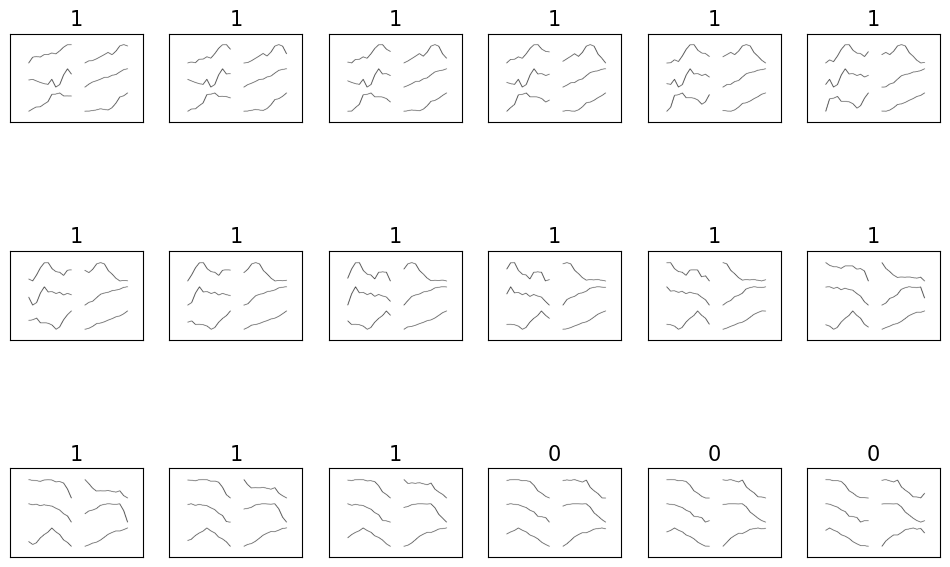

In [37]:
ds_train = ds_images_labels.batch(18)
images, labels = next(iter(ds_train))

fig = plt.figure(figsize=(12, 8))
for i,(image,label) in enumerate(zip(images, labels)):
    ax = fig.add_subplot(3, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image)
    ax.set_title('{}'.format(label), size=15)
    
plt.show()

In [38]:
ds_train = ds_images_labels.shuffle(buffer_size=100,
                                  reshuffle_each_iteration=False)

mnist_train_all = ds_train.take(500)
mnist_valid = mnist_train_all.skip(400).batch(40)
mnist_train = mnist_train_all.take(100).batch(40)
mnist_test = ds_train.skip(500)

In [43]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))
    
model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))
    
model.add(tf.keras.layers.Dense(
    units=2, name='fc_2',
    activation='softmax'))

In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`

history = model.fit(mnist_train, epochs=10, 
                    validation_data=mnist_valid, 
                    shuffle=True)

Epoch 1/10
3/3 [==============================] - 9s 2s/step - loss: 26.7195 - accuracy: 0.5700 - val_loss: 0.5079 - val_accuracy: 0.9000
Epoch 2/10
3/3 [==============================] - 6s 2s/step - loss: 3.4252 - accuracy: 0.7000 - val_loss: 7.4505 - val_accuracy: 0.1000
Epoch 3/10
3/3 [==============================] - 6s 2s/step - loss: 2.3742 - accuracy: 0.4300 - val_loss: 0.2580 - val_accuracy: 0.9000
Epoch 4/10
3/3 [==============================] - 6s 2s/step - loss: 0.5956 - accuracy: 0.7000 - val_loss: 0.5051 - val_accuracy: 0.9500
Epoch 5/10
3/3 [==============================] - 6s 2s/step - loss: 0.4579 - accuracy: 0.9200 - val_loss: 0.3107 - val_accuracy: 0.9300
Epoch 6/10
3/3 [==============================] - 6s 2s/step - loss: 0.1918 - accuracy: 0.9300 - val_loss: 0.1917 - val_accuracy: 0.9200
Epoch 7/10
3/3 [==============================] - 6s 2s/step - loss: 1.1809 - accuracy: 0.7000 - val_loss: 0.3041 - val_accuracy: 0.9100
Epoch 8/10
3/3 [========================

In [45]:
num=len(mnist_test)

test_results = model.evaluate(mnist_test.batch(num))

1/1 [==============================] - 1s 1s/step - loss: 0.2903 - accuracy: 0.8617


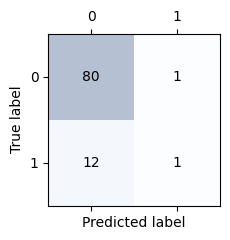

In [46]:
batch_test=next(iter(mnist_test.batch(94)))

preds = model(batch_test[0])
preds = tf.argmax(preds, axis=1)

images, labels = next(iter(mnist_test.batch(94)))

y_pred=preds.numpy()
y_test=labels.numpy()

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

## 5. Conclusion

In this project, we use a variety of methods to identify and predict recessions. Following the traditional Hidden Markov Chain Factor Model approach, the accuracy is less than 90%. Meanwhile, the machine learning approach can achieve an accuracy and ROC AUC of over 90% by using economic data within one year. The same approach also performs well in predicting whether or not a recession will occur in the next six months, with an accuracy of around 85%. In particular, semi-auto feature selection performs well in different scenarios.

We are more interested in whether machines can tell if a recession is going to occur just by looking at an figure, just as a human could. We make a simple neural network model and train it to recognize economic figures and observe an accuracy of 0.86, which suggests that there may actually be some pattern of the economic crisis.

Such a project could be further developed in the future. Hyper-parameters can be chosen more carefully (i.e., using 18 months data to predict recession in 3 months) to get better scores. Also it might be possible to build more complex neural network models that can recognize recession patterns by inputting single variable economics plots.

## References

1. Moro, S., Cortez, P., & Rita, P. (2014). A data-driven approach to predict the success of bank telemarketing. *Decision Support Systems*, *62*, 22-31.

## Appendix

> **Indian Joke about Weather**
> 
> Fall was upon a remote reservation when the Indian tribe asked their new Chief what the coming winter was going to be like. The modern day Chief had never been taught the secrets of the ancients. When he looked at the sky he couldn't tell what the winter was going to be like.
> 
> Better safe than sorry, he said to himself and told his tribe that the winter was indeed expected to be cold and that the members of the village should stock up on firewood to be prepared.
> 
> After several days, our modern Chief got an idea. He went to the phone booth, called the National Weather Service and asked, "Is the coming winter going to be cold?"
> 
>"It looks like this winter is going to be quite cold," the meteorologist at the weather service responded.
>
> So the Chief went back to his people and told them to collect even more firewood in order to be prepared. A week later he called the National Weather Service again. "Does it still look like it is going to be a very cold winter?"
> 
> "Yes," the man at National Weather Service again replied, "It's going to be a very cold winter."
> 
> The Chief again went back to his people and ordered them to collect every scrap of firewood they could find. Two weeks later the Chief called the National Weather Service again. "Are you absolutely sure that the winter is going to be very cold?"
> 
> "Absolutely," the man replied. "It's looking more and more like it is going to be one of the coldest winters ever."
> 
> "How can you be so sure?" the Chief asked.
> 
> The weatherman replied, "The Indians are collecting firewood like crazy."